In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
path = 'C:\dataset'

In [4]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

vt_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = datasets.ImageFolder(path)

train_size = int(0.80 * len(dataset))
val_size = int(0.10 * len(dataset))
test_size = len(dataset) - train_size - val_size


indices = list(range(len(dataset)))
np.random.shuffle(indices)


train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]


train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

print(len(train_dataset), len(val_dataset), len(test_dataset))

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = vt_transform
test_dataset.dataset.transform = vt_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

2563 320 321


In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 5)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.leaky_relu(self.conv1(x), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.conv2(x), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.conv3(x), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.conv4(x), negative_slope=0.01))
        x = x.view(-1, 256 * 16 * 16)
        x = self.dropout(F.leaky_relu(self.fc1(x), negative_slope=0.01))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train
num_epochs = 12

train_losses = [] 
train_accuracies = [] 
val_losses = []   
val_accuracies = [] 


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()
    
    train_losses.append(running_loss / len(train_loader)) 
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)  
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_losses.append(val_loss / len(val_loader))  
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy) 
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy:.2f}%")
    print("\n")


torch.save(model.state_dict(), 'simple_cnn_model.pth')


# Evaluate
model.eval()
test_loss = 0.0
correct = 0
total = 0
test_predictions = []
test_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_predictions.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Epoch [1/12], Loss: 1.4305, Accuracy: 37.53%
Validation Loss: 1.3258, Accuracy: 46.88%


Epoch [2/12], Loss: 1.2129, Accuracy: 49.79%
Validation Loss: 1.3031, Accuracy: 46.56%


Epoch [3/12], Loss: 1.0867, Accuracy: 56.69%
Validation Loss: 1.0945, Accuracy: 55.62%


Epoch [4/12], Loss: 0.9338, Accuracy: 65.08%
Validation Loss: 1.2947, Accuracy: 51.56%


Epoch [5/12], Loss: 0.7700, Accuracy: 70.46%
Validation Loss: 1.0170, Accuracy: 60.31%


Epoch [6/12], Loss: 0.4301, Accuracy: 85.56%
Validation Loss: 0.9803, Accuracy: 65.31%


Epoch [7/12], Loss: 0.3222, Accuracy: 89.62%
Validation Loss: 1.0181, Accuracy: 65.62%


Epoch [8/12], Loss: 0.2432, Accuracy: 92.27%
Validation Loss: 1.0317, Accuracy: 65.94%


Epoch [9/12], Loss: 0.1931, Accuracy: 94.58%
Validation Loss: 1.0915, Accuracy: 66.56%


Epoch [10/12], Loss: 0.1399, Accuracy: 95.79%
Validation Loss: 1.1684, Accuracy: 66.56%


Epoch [11/12], Loss: 0.0964, Accuracy: 98.09%
Validation Loss: 1.1623, Accuracy: 65.94%


Epoch [12/12], Loss

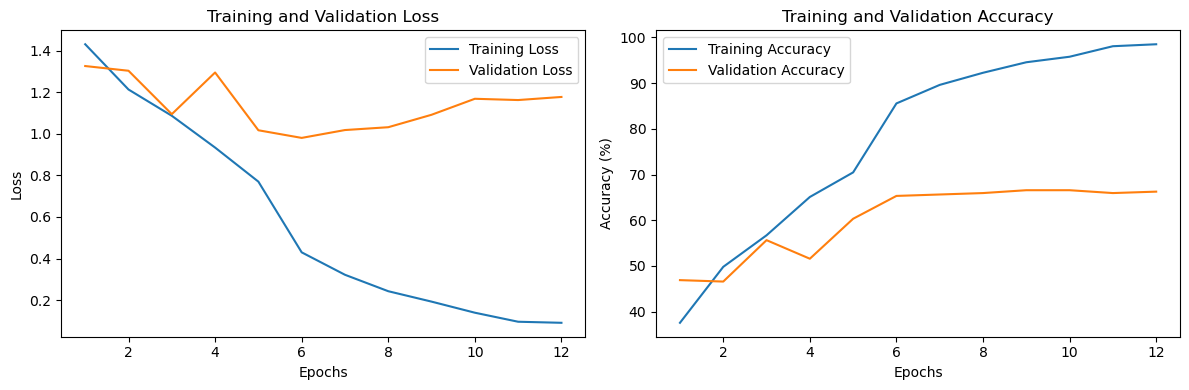

In [7]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


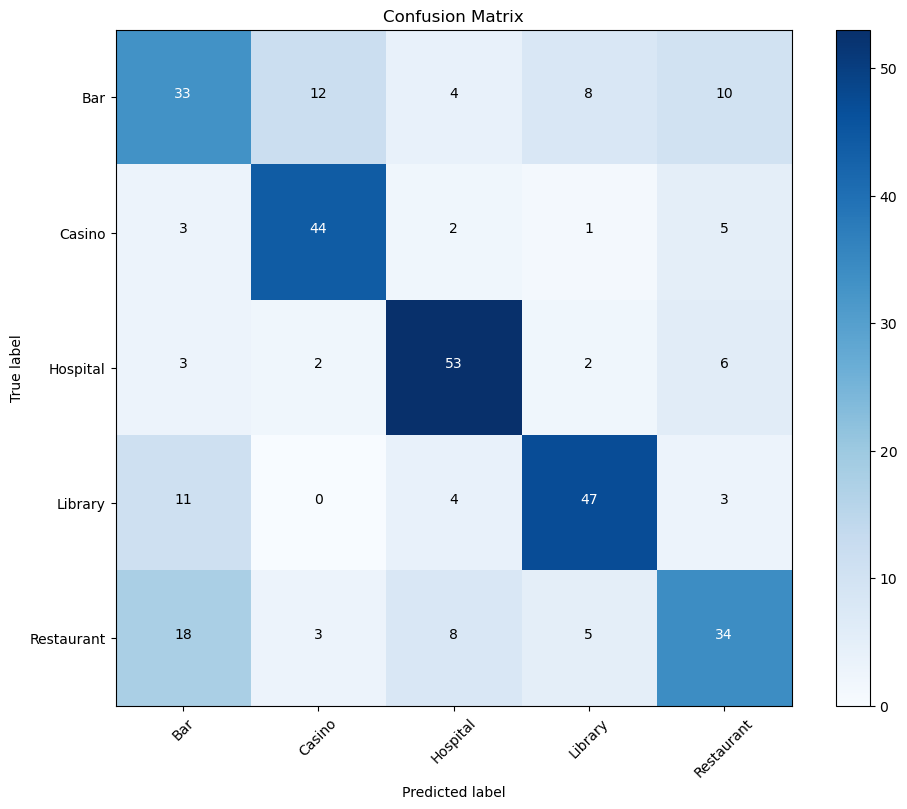

Classification Report:
              precision    recall  f1-score   support

         Bar       0.49      0.49      0.49        67
      Casino       0.72      0.80      0.76        55
    Hospital       0.75      0.80      0.77        66
     Library       0.75      0.72      0.73        65
  Restaurant       0.59      0.50      0.54        68

    accuracy                           0.66       321
   macro avg       0.66      0.66      0.66       321
weighted avg       0.65      0.66      0.65       321



In [8]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

conf_matrix = confusion_matrix(test_labels, test_predictions)
plot_confusion_matrix(conf_matrix, classes=dataset.classes, title='Confusion Matrix')

class_report = classification_report(test_labels, test_predictions, target_names=dataset.classes)
print('Classification Report:')
print(class_report)
